In [ ]:
!pip install pyod
!pip install tensorflow

In [41]:
import numpy as np
import pyod
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.io import loadmat
from pyod.models.pca import PCA
from pyod.models.kpca import KPCA
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense

In [3]:
data = np.random.multivariate_normal(mean=[5, 10, 2], cov=[[3, 2, 2], [2, 10, 1], [2, 1, 2]], size=500)

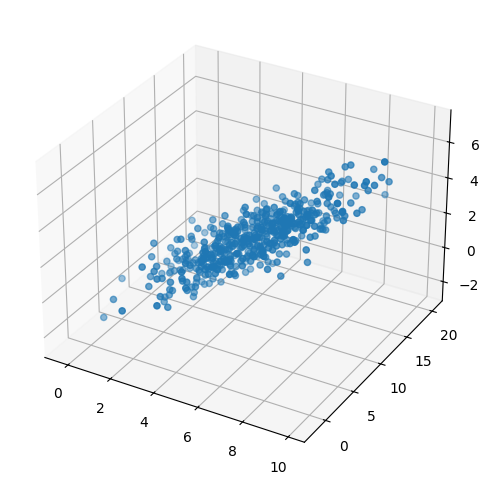

In [4]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(data[:,:1], data[:,1:2], data[:,2:])
plt.show()

In [5]:
# mean-centering data
centered_data = data.copy()

centered_data[:,:1] -= np.mean(centered_data[:,:1])
centered_data[:,1:2] -= np.mean(centered_data[:,1:2])
centered_data[:,2:] -= np.mean(centered_data[:,2:])

In [6]:
# calculating covariance matrix

cov_mat = np.matmul(centered_data.T, centered_data) / (centered_data.shape[0])

print(cov_mat)

[[ 3.20384068  2.64658831  2.25561533]
 [ 2.64658831 11.30856273  1.42846602]
 [ 2.25561533  1.42846602  2.27676809]]


In [7]:
# calculating eigenvalues and eigenvectors

eigenvalues, eigenvectors = np.linalg.eig(cov_mat)

print(eigenvalues)
print(eigenvectors)

[12.5044437   0.40213529  3.88259251]
[[-0.31251065 -0.66102217  0.68219263]
 [-0.9289089   0.06246789 -0.36500139]
 [-0.19865888  0.74776163  0.63355125]]


In [8]:
original_variance_cumsum = np.cumsum([cov_mat[0][0], cov_mat[1][1], cov_mat[2][2]])
pca_variance_cumsum = np.cumsum(eigenvalues)

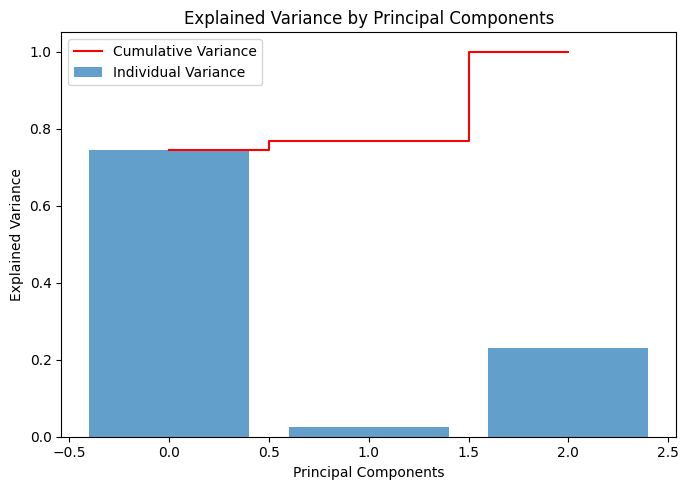

In [9]:
individual_variances = eigenvalues / np.sum(eigenvalues)

cumulative_variance = np.cumsum(individual_variances)

fig, ax = plt.subplots(figsize=(7, 5))

ax.bar(range(0, len(individual_variances)), individual_variances, alpha=0.7, label='Individual Variance')
ax.step(range(0, len(cumulative_variance)), cumulative_variance, where='mid', color='red', label='Cumulative Variance')

ax.set_xlabel('Principal Components')
ax.set_ylabel('Explained Variance')
ax.set_title('Explained Variance by Principal Components')
ax.legend()

plt.tight_layout()
plt.show()

In [10]:
projected_data = np.dot(centered_data, eigenvectors)

deviation_3rd_component = np.absolute(projected_data[:,2:].flatten() - np.mean(projected_data[:,2:].flatten()))
threshold = np.quantile(deviation_3rd_component, 0.9)

anomaly_indices = np.where(deviation_3rd_component >= threshold)
anomaly_label = [0 if idx in anomaly_indices[0] else 1 for idx in range(projected_data.shape[0])]

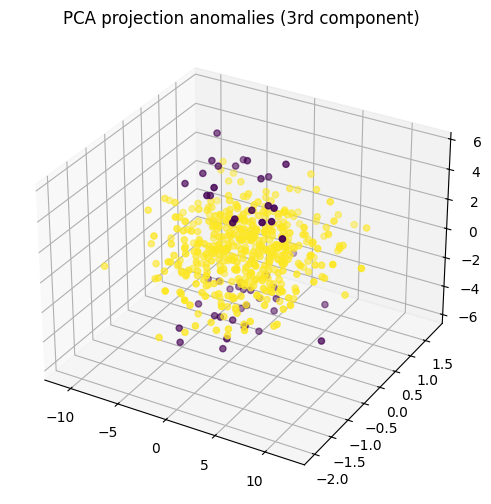

In [11]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(projected_data[:,:1], projected_data[:,1:2], projected_data[:,2:], c=anomaly_label)
plt.title('PCA projection anomalies (3rd component)')
plt.show()

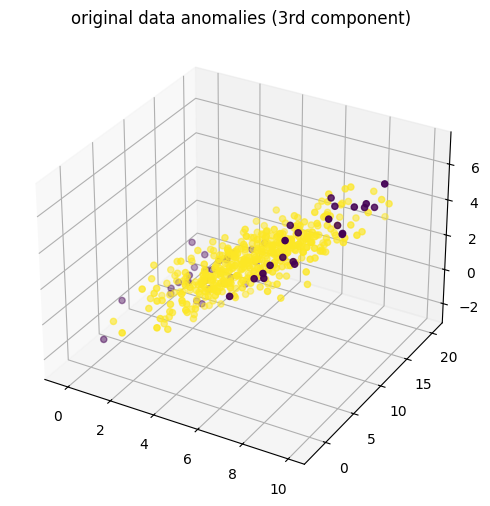

In [12]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(data[:,:1], data[:,1:2], data[:,2:], c=anomaly_label)
plt.title('original data anomalies (3rd component)')
plt.show()

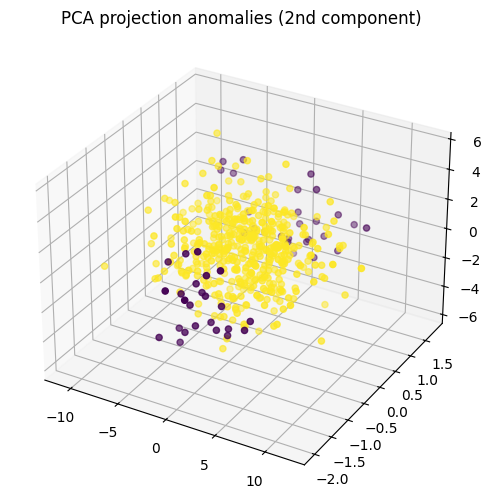

In [13]:
deviation_2rd_component = np.absolute(projected_data[:,1:2].flatten() - np.mean(projected_data[:,1:2].flatten()))
threshold = np.quantile(deviation_2rd_component, 0.9)

anomaly_indices = np.where(deviation_2rd_component >= threshold)
anomaly_label = [0 if idx in anomaly_indices[0] else 1 for idx in range(projected_data.shape[0])]

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(projected_data[:,:1], projected_data[:,1:2], projected_data[:,2:], c=anomaly_label)
plt.title('PCA projection anomalies (2nd component)')
plt.show()

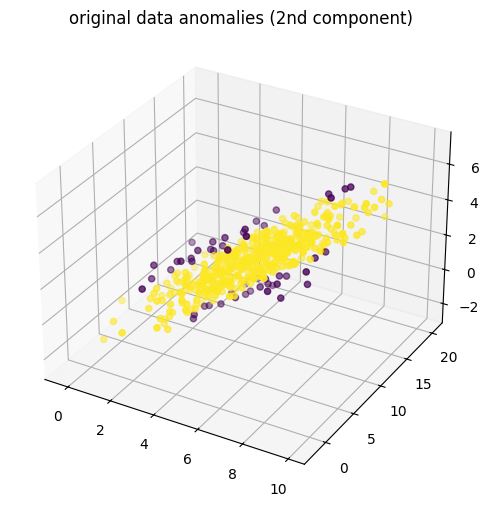

In [14]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(data[:,:1], data[:,1:2], data[:,2:], c=anomaly_label)
plt.title('original data anomalies (2nd component)')
plt.show()

In [15]:
# identify the outliers based on the
# normalized distance (by the corresponding standard deviation) of the data
# points to the centroid

centroid = np.mean(projected_data, axis=0)
std_devs = np.std(projected_data, axis=0)
distances = (projected_data - centroid) / std_devs

# considering that anomalies are more that 2 standard deviations away from the centroid
threshold = 2
#anomaly_indices = np.any(distances >= threshold, axis=1)
#anomaly_label = [0 if idx in anomaly_indices[0] else 1 for idx in range(projected_data.shape[0])]

anomaly_label = np.array(np.any(distances >= threshold, axis=1), dtype=np.int32)

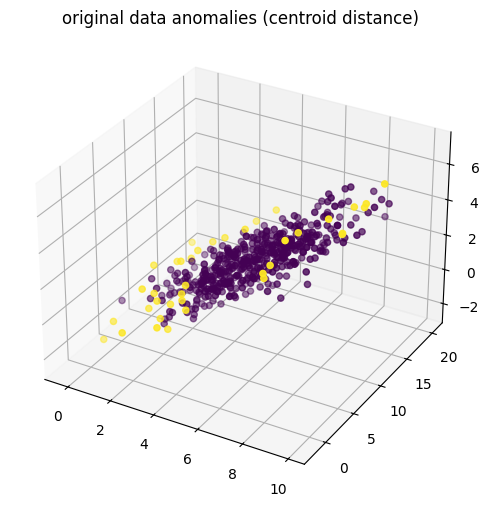

In [16]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(data[:,:1], data[:,1:2], data[:,2:], c=anomaly_label)
plt.title('original data anomalies (centroid distance)')
plt.show()

In [17]:
# Exercise 2

!gdown 1xoT2nSQYkghfi7286BM_nu8VC9NVvMww

Downloading...
From (original): https://drive.google.com/uc?id=1xoT2nSQYkghfi7286BM_nu8VC9NVvMww
From (redirected): https://drive.google.com/uc?id=1xoT2nSQYkghfi7286BM_nu8VC9NVvMww&confirm=t&uuid=849360e3-69ea-4598-8118-1ad295486ec3
To: /content/shuttle 1.mat
100% 345k/345k [00:00<00:00, 8.86MB/s]


In [18]:
data = loadmat('/content/shuttle 1.mat')

X = data['X']
y = data['y']

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=42)

(49097, 9)
(49097, 1)


In [20]:
count0 = np.sum(y_train == 0)
count1 = np.sum(y_train == 1)

train_contamination_rate = count1 / count0

pca_model = PCA(contamination=train_contamination_rate)

pca_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/pyod/models/base.py:423: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


PCA(contamination=0.0791295746785361, copy=True, iterated_power='auto',
  n_components=None, n_selected_components=None, random_state=None,
  standardization=True, svd_solver='auto', tol=0.0, weighted=True,
  whiten=False)

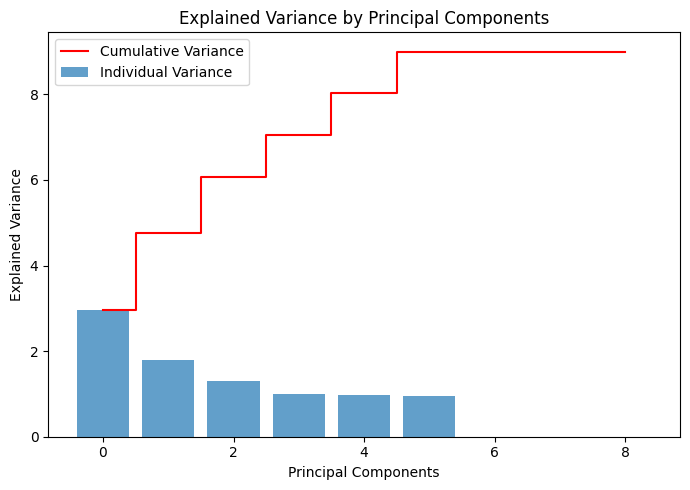

In [24]:
individual_variances = pca_model.explained_variance_

cumulative_variance = np.cumsum(individual_variances)

fig, ax = plt.subplots(figsize=(7, 5))

ax.bar(range(0, len(individual_variances)), individual_variances, alpha=0.7, label='Individual Variance')
ax.step(range(0, len(cumulative_variance)), cumulative_variance, where='mid', color='red', label='Cumulative Variance')

ax.set_xlabel('Principal Components')
ax.set_ylabel('Explained Variance')
ax.set_title('Explained Variance by Principal Components')
ax.legend()

plt.tight_layout()
plt.show()

In [30]:
train_preds = pca_model.predict(X_train)
test_preds = pca_model.predict(X_test)

print('PCA train BA:', round(balanced_accuracy_score(y_train, train_preds), 4))
print('PCA test BA:', round(balanced_accuracy_score(y_test, test_preds), 4))

PCA train BA: 0.9706
PCA test BA: 0.974


In [42]:
# Exercise 3

data = loadmat('/content/shuttle 1.mat')

X = data['X']
y = data['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

scaler = MinMaxScaler()
scaler = scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [43]:
class Autoencoder(Model):
  def __init__(self):
      super(Autoencoder, self).__init__()

      self.encoder = Sequential([Dense(8, activation='relu'), Dense(5, activation='relu'), Dense(3, activation='relu')])
      self.decoder = Sequential([Dense(5, activation='relu'), Dense(8, activation='relu'), Dense(9, activation='sigmoid')])

  def call(self, input):
      x1 = self.encoder(input)
      x2 = self.decoder(x1)

      return x2

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0244 - val_loss: 0.0209
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0203 - val_loss: 0.0188
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0182 - val_loss: 0.0167
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0162 - val_loss: 0.0145
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0140 - val_loss: 0.0124
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0119 - val_loss: 0.0103
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0099 - val_loss: 0.0084
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0080 - val_loss: 0.0069
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0057
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0055 - val_loss: 0.0049
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

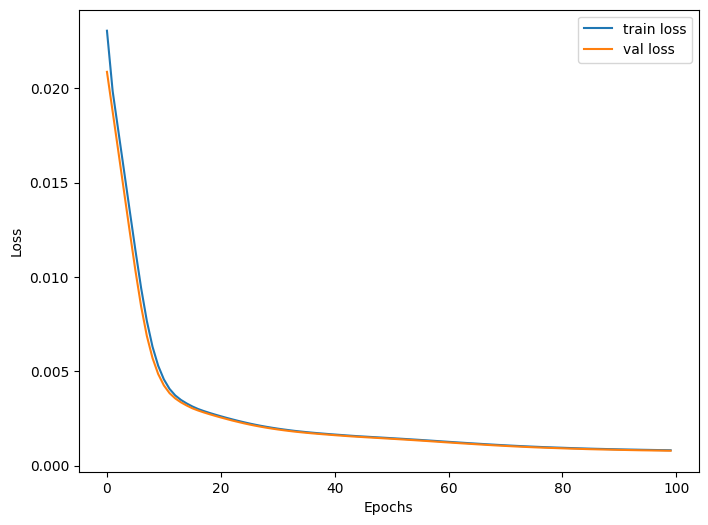

In [47]:
model = Autoencoder()
model.compile(optimizer='adam', loss='mse')

stats = model.fit(
  X_train, X_train,
  epochs=100,
  batch_size=1024,
  validation_data=(X_test, X_test),
  verbose=1
)

plt.figure(figsize=(8, 6))
plt.plot(stats.history['loss'], label='train loss')
plt.plot(stats.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()